In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import classification_report as report
from sklearn.preprocessing import StandardScaler


In [164]:
#tfidf features
#tfidf_words = ['left', 'hospital', 'right', 'small', 'blood', 'patient', 'daily', 'assessment', 'clear', 'noted', 'action', 'pulmonary', 'response', 'plan', 'pain', 'stable', 'hct', 'fluid', 'meq', 'urine', 'continue', 'chest', 'clip', 'number', 'radiology', 'reason', 'medical', 'year', 'old', 'examination', 'final', 'report', 'day', 'status', 'present', 'normal', 'tube', 'acute', 'respiratory', 'failure', 'care', 'history', 'icu', 'tablet', 'lung', 'given', 'seen', 'line', 'contrast', 'valve']
#tfidf_words
chest 	0.033754
care 	0.032076
urine 	0.030525
day 	0.030009
final 	0.029927
lung 	0.028957
seen 	0.028083
patient 0.027310
report 	0.027091
year 	0.026016
daily 	0.025909
hct 	0.024847
tablet 	0.024462
blood 	0.023880
respiratory 	0.023798
examination 	0.023738
right 	0.023121
icu 	0.022048
valve 	0.021717
radiology 	0.020575
line 	0.020083
medical 	0.019867
meq 	0.019810
clear 	0.019440
status 	0.019176
plan 	0.019171
response 	0.019155
acute 	0.018978
clip 	0.018692
present 	0.018413
stable 	0.018383
hospital 	0.018349
history 	0.018278
number 	0.017874
tube 	0.017609
small 	0.017253
old 	0.017168
normal 	0.017150
fluid 	0.016643
pulmonary 	0.016506
pain 	0.015255
assessment 	0.015216
failure 	0.014833
noted 	0.011953
left 	0.011104
continue 	0.009939
contrast 	0.008908
reason 	0.008502
action 	0.006570
given 	0.001878


In [143]:
#lab data, extracted from mimic, preprocessed
#forecasts from strats model, trained on train data, and then tasked to forecast test patients that it did never encounter during training. It got 4 hours of input and forecast 12 next hours.
notext = pd.read_csv("patients_no_text_sepsis_labels.csv")
no_text_forecasts = pd.read_pickle("Experiments/strats_base_FFN_test.pkl")
notext_forecasts = no_text_forecasts[0]
notext_var_map = list(no_text_forecasts[1].keys())

sBert = pd.read_csv("lab_sBert_concat_fulldata.csv")
s_Bert_forecasts = pd.read_pickle("Experiments/strats_SBERT_test.pkl")
sBert_forecasts = s_Bert_forecasts[0]
sBert_var_map = list(s_Bert_forecasts[1].keys())

tfidf = pd.read_csv("lab_tfidf_fulldata.csv")
tf_idf_forecasts = pd.read_pickle("Experiments/strats_tfidf_FFN_test.pkl")
tfidf_forecasts = tf_idf_forecasts[0]
tfidf_var_map = list(tf_idf_forecasts[1].keys())

In [126]:
#preprocess data like standard model
notext_targets = notext[["m:icustayid", "sepsis_label", "step"]]
notext_rows = notext.drop(columns=["o:age", "o:gender","m:icustayid", "sepsis_label","m:charttime", "traj", "step", "r:reward", "a:action","Unnamed: 0", "Unnamed: 0.1", "m:presumed_onset", "o:cumulated_balance", "o:re_admission", "o:output_4hourly", "o:output_total", "o:PaO2_FiO2", "o:input_total"])
notext_var_map=list(notext_rows.columns)
notext_scaler = StandardScaler()
notext_rows[notext_rows.columns] = notext_scaler.fit_transform(notext_rows[notext_rows.columns])

notext_rows["m:icustayid"] = notext_targets["m:icustayid"]
notext_rows["sepsis_label"] = notext_targets["sepsis_label"]
notext_rows["step"] = notext_targets["step"]

notext_min_max = pd.DataFrame({"min": notext_rows.min(), "max": notext_rows.max()})
#notext_min_max

In [127]:
#preprocess data like sbert model
sBert_targets = sBert[["m:icustayid", "sepsis_label", "step"]]
sBert_rows = sBert.drop(columns=["hour","clean_text","Unnamed: 0.2","Unnamed: 0.1","Unnamed: 0","o:age", "o:gender","m:icustayid", "sepsis_label","m:charttime", "traj", "step", "r:reward", "a:action","Unnamed: 0", "Unnamed: 0.1", "m:presumed_onset", "o:cumulated_balance", "o:re_admission", "o:output_4hourly", "o:output_total", "o:PaO2_FiO2", "o:input_total"])
sBert_var_map=list(sBert_rows.columns)
sBert_scaler = StandardScaler()
sBert_rows[sBert_rows.columns] = sBert_scaler.fit_transform(sBert_rows[sBert_rows.columns])

sBert_rows["m:icustayid"] = sBert_targets["m:icustayid"]
sBert_rows["sepsis_label"] = sBert_targets["sepsis_label"]
sBert_rows["step"] = sBert_targets["step"]

sBert_min_max = pd.DataFrame({"min": sBert_rows.min(), "max": sBert_rows.max()})
#sBert_min_max

In [144]:
#preprocess data like tfidf model
tfidf_targets = tfidf[["m:icustayid", "sepsis_label", "step"]]
tfidf_rows = tfidf.drop(columns=['o:cumulated_balance','o:output_total','o:input_total','o:PaO2_FiO2','o:output_4hourly',"clean_text",'a:action',"o:re_admission",'m:charttime','m:presumed_onset','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.2','r:reward','step','traj',"o:age", "o:gender","m:icustayid", "sepsis_label", "hour"])
tfidf_var_map=list(tfidf_rows.columns)
#lab_cols_ = list(tfidf_rows.columns)
#lab_cols = [x for x in lab_cols_ if "tfidf" not in x]
tfidf_scaler = StandardScaler()
#tfidf_rows[lab_cols] = tfidf_scaler.fit_transform(tfidf_rows[lab_cols])

tfidf_rows[tfidf_rows.columns] = tfidf_scaler.fit_transform(tfidf_rows[tfidf_rows.columns])

tfidf_rows["m:icustayid"] = tfidf_targets["m:icustayid"]
tfidf_rows["sepsis_label"] = tfidf_targets["sepsis_label"]
tfidf_rows["step"] = tfidf_targets["step"]

tfidf_min_max = pd.DataFrame({"min": tfidf_rows.min(), "max": tfidf_rows.max()})
#min_max

In [145]:
for i in tfidf_var_map:
    print(i)

o:Arterial_BE
o:Arterial_lactate
o:Arterial_pH
o:BUN
o:Calcium
o:Chloride
o:Creatinine
o:DiaBP
o:FiO2_1
o:GCS
o:Glucose
o:HCO3
o:HR
o:Hb
o:INR
o:Magnesium
o:MeanBP
o:PT
o:PTT
o:Platelets_count
o:Potassium
o:RR
o:SGOT
o:SGPT
o:SIRS
o:SOFA
o:Shock_Index
o:Sodium
o:SpO2
o:SysBP
o:Temp_C
o:Total_bili
o:WBC_count
o:Weight_kg
o:input_4hourly
o:max_dose_vaso
o:mechvent
o:paCO2
o:paO2
tfidf:0
tfidf:1
tfidf:2
tfidf:3
tfidf:4
tfidf:5
tfidf:6
tfidf:7
tfidf:8
tfidf:9
tfidf:10
tfidf:11
tfidf:12
tfidf:13
tfidf:14
tfidf:15
tfidf:16
tfidf:17
tfidf:18
tfidf:19
tfidf:20
tfidf:21
tfidf:22
tfidf:23
tfidf:24
tfidf:25
tfidf:26
tfidf:27
tfidf:28
tfidf:29
tfidf:30
tfidf:31
tfidf:32
tfidf:33
tfidf:34
tfidf:35
tfidf:36
tfidf:37
tfidf:38
tfidf:39
tfidf:40
tfidf:41
tfidf:42
tfidf:43
tfidf:44
tfidf:45
tfidf:46
tfidf:47
tfidf:48
tfidf:49


In [139]:
def restore_predictions(predictions, mapping):
    l = []
    leng = len(predictions.iloc[0]) / len(mapping)
    for i in range(len(predictions)):
        arr = np.asarray(predictions.iloc[i]).reshape((int(leng),len(mapping)))
        l.append(arr)
    df = pd.concat([pd.DataFrame(arr) for arr in l])#, keys=np.arange(len(l)))
    
    df.columns=mapping
    return df

In [152]:
#select ids that have data for necessary amount of steps
observed_steps = 4
forecast_steps = 24
notext_IDS = list(np.unique(notext["m:icustayid"].loc[notext["step"] >= forecast_steps+observed_steps]))
notext_fo_IDs = notext_forecasts["SUBJECT_ID"].loc[notext_forecasts["SUBJECT_ID"].isin(notext_IDS)]

#select observed data based on the ids
notext_observe = notext.loc[notext["m:icustayid"].isin(notext_fo_IDs)]
#select gold values of the steps that were forecast
notext_observe_targets = notext_observe[notext_var_map][(notext_observe['step'] > observed_steps) & (notext_observe['step'] <= observed_steps+forecast_steps)]
notext_step = notext_observe["step"][(notext_observe['step'] > observed_steps) & (notext_observe['step'] <= observed_steps+forecast_steps)]
notext_step = notext_step-4
notext_st = pd.DataFrame(notext_step, columns=["step"])
notext_st = notext_st.reset_index().drop(columns="index")
#bring forecasts in correct format
notext_fo = restore_predictions(notext_forecasts["forecasting_pred"].loc[notext_forecasts["SUBJECT_ID"].isin(notext_IDS)], notext_var_map)
#bring observed in correct format
notext_observe_targets = notext_observe_targets.reset_index().drop(columns="index")
notext_fo = notext_fo.reset_index().drop(columns="index")
#compute MSE: for each step, Mean for all variables, of the squared difference between forecast and target
notext_MSE = np.mean((notext_fo - notext_observe_targets)**2, axis=1)
notext_st["mse"] = notext_MSE




In [153]:
observed_steps = 4
forecast_steps = 24
sBert_IDS = list(np.unique(sBert["m:icustayid"].loc[sBert["step"] >= forecast_steps+observed_steps]))

sBert_fo_IDs = sBert_forecasts["SUBJECT_ID"].loc[sBert_forecasts["SUBJECT_ID"].isin(sBert_IDS)]
sBert_observe = sBert.loc[sBert["m:icustayid"].isin(sBert_fo_IDs)]
sBert_observe_targets = sBert_observe[sBert_var_map][(sBert_observe['step'] > observed_steps) & (sBert_observe['step'] <= observed_steps+forecast_steps)]
sBert_step = sBert_observe["step"][(sBert_observe['step'] > observed_steps) & (sBert_observe['step'] <= observed_steps+forecast_steps)]
sBert_step = sBert_step-4
sBert_st = pd.DataFrame(sBert_step, columns=["step"])
sBert_st = sBert_st.reset_index().drop(columns="index")
sBert_fo = restore_predictions(sBert_forecasts["forecasting_pred"].loc[sBert_forecasts["SUBJECT_ID"].isin(sBert_IDS)], sBert_var_map)
sBert_observe_targets = sBert_observe_targets.reset_index().drop(columns="index")
sBert_fo = sBert_fo.reset_index().drop(columns="index")
sBert_MSE = np.mean((sBert_fo - sBert_observe_targets)**2, axis=1)
sBert_st["mse"] = sBert_MSE




In [154]:
observed_steps = 4
forecast_steps = 24
tfidf_IDS = list(np.unique(tfidf["m:icustayid"].loc[tfidf["step"] >= forecast_steps+observed_steps]))

tfidf_fo_IDs = tfidf_forecasts["SUBJECT_ID"].loc[tfidf_forecasts["SUBJECT_ID"].isin(tfidf_IDS)]
tfidf_observe = tfidf.loc[tfidf["m:icustayid"].isin(tfidf_fo_IDs)]
tfidf_observe_targets = tfidf_observe[tfidf_var_map][(tfidf_observe['step'] > observed_steps) & (tfidf_observe['step'] <= observed_steps+forecast_steps)]
tfidf_step = tfidf_observe["step"][(tfidf_observe['step'] > observed_steps) & (tfidf_observe['step'] <= observed_steps+forecast_steps)]
tfidf_step = tfidf_step-4
tfidf_st = pd.DataFrame(tfidf_step, columns=["step"])
tfidf_st = tfidf_st.reset_index().drop(columns="index")
tfidf_fo = restore_predictions(tfidf_forecasts["forecasting_pred"].loc[tfidf_forecasts["SUBJECT_ID"].isin(tfidf_IDS)], tfidf_var_map)
tfidf_observe_targets = tfidf_observe_targets.reset_index().drop(columns="index")
tfidf_fo = tfidf_fo.reset_index().drop(columns="index")
tfidf_MSE = np.mean((tfidf_fo - tfidf_observe_targets)**2, axis=1)
tfidf_st["mse"] = tfidf_MSE




In [155]:
len(tfidf_forecasts["forecasting_pred"][0]) / len(tfidf_var_map)

24.0

Average MSE of Lab Features
notext    1.389862
sBert     1.289666
tfidf     1.119620
dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

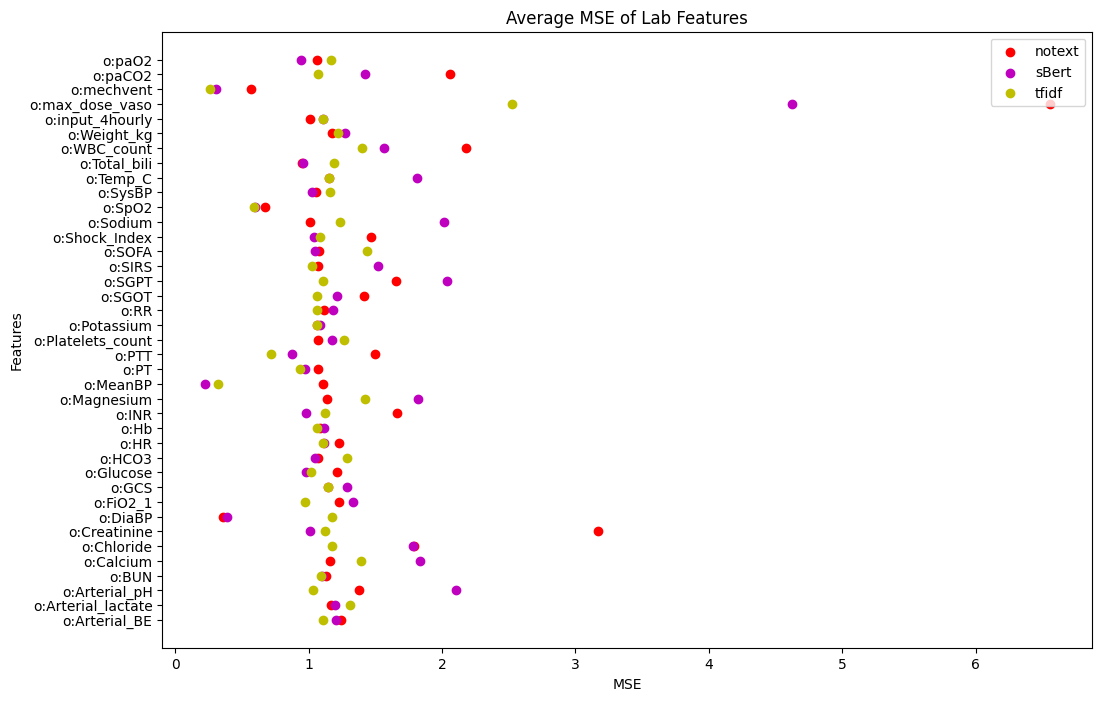

In [165]:
notext_variable_mse = np.mean((notext_fo - notext_observe_targets)**2, axis=0)
sBert_variable_mse = np.mean((sBert_fo - sBert_observe_targets)**2, axis=0)
tfidf_variable_mse = np.mean((tfidf_fo - tfidf_observe_targets)**2, axis=0)

laboratory_only_mse = pd.DataFrame({"notext": notext_variable_mse.values, "sBert": sBert_variable_mse[:len(notext_var_map)].values, "tfidf": tfidf_variable_mse[:len(notext_var_map)].values}, index=notext_var_map)
#laboratory_only_mse = laboratory_only_mse.sort_values(by=["notext"])
print("Average MSE of Lab Features")
print(laboratory_only_mse.mean())
fig = plt.figure(figsize=(12,8))
fig.tight_layout()
i, color = -1, ['r', 'm', 'y']
for frame in [laboratory_only_mse["notext"], laboratory_only_mse["sBert"], laboratory_only_mse["tfidf"]]:
    i+=1
    c = color[i]
    plt.scatter(frame.values, frame.index, color=c)
    #plt.plot(frame.values, frame.index, color=c)
    #plt.plot(([frame.values.mean()]*len(notext_var_map)), frame.index, color=c) 
    
plt.title("Average MSE of Lab Features")
plt.xlabel("MSE")
plt.ylabel("Features")
plt.legend(['notext','sBert', 'tfidf'],loc='upper right')  
plt.show

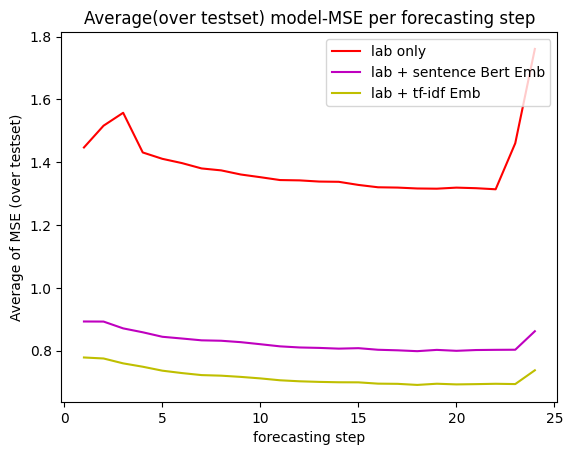

In [148]:
notext_step_wise_mse_mean = notext_st.groupby("step").mean()
sBert_step_wise_mse_mean = sBert_st.groupby("step").mean()
tfidf_step_wise_mse_mean = tfidf_st.groupby("step").mean()

fig = plt.figure()
i, color = 0, ['r', 'm', 'y']
for frame in [notext_step_wise_mse_mean, sBert_step_wise_mse_mean, tfidf_step_wise_mse_mean]:
    c = color[i]
    plt.plot(frame.index, frame['mse'], color=c)
    i+=1

#plt.xlim(0,18000)
#plt.ylim(0,30)
plt.title("Average(over testset) model-MSE per forecasting step")
plt.xlabel("forecasting step")
plt.ylabel("Average of MSE (over testset)")
plt.legend(['lab only','lab + sentence Bert Emb', 'lab + tf-idf Emb'],loc='upper right')     
plt.show()


Q: Why is tfidf better than sentence Bert? 
Since I am using sentence Bert embeddings and tfidf vectors as INPUT FEATURES, as in, it is treated the same as MeanBP, Temperature etc, and as such also part of the forecast i obtain from strats here are some suspicions. 
Both SentenceBert Embeddings and TFIDF Vectors are representing semantics of text, thus, an accurate forecasting of these features introduces useful information. As far as i understand, the original BERT embeddings were not meant for semantic interpretation, and thus, in theory, it would not work.

Forecasting TF-IDF is essentially forecasting the occurence of important words, so words that play a big role in identifying the target.


--------------------

Fix numpy seed, masking muss rein, Reprpoducability!!!! d.h. ich muss herusfinden wie ich die imputed features remove!!! https://github.com/JINHXu/Early-Sepsis-Prediction-using-TSF/blob/main/data_prep_and_exploration/mimic_preprocessed_data_generation.py vlt ist das unser MIMIC-III mit text! DannText wieder preprocessen? Dann rerun training... sounds simple. MSE benutzen.

Why does stuff work? Sind tfidf und sbert embeddings semantic useful? Does it work? Control Experiments? Adde noise als alternative feature, was passiert? prob keine Zeit. Was könnten alternativen sein.

Für die 40 seiten muss ich ALLES was geht in Formeln bringen, sprich alle losses, PCA, sBert, tfidf, Fourier, feature averages, Model graph bzw bild.